# EDA

In this EDA notebook. We examine the properties of the data in order to:
1. Evaluate if the NLI_M model proposed by Sun et al. can be used. 
2. Establish the Naive Baseline by:
    * Calculating the average number aspect categories associated with a review
    * The most common aspect categories
    * The average probabilty weights of different sentiments by aspect categories
3. Explore label proportion when applying different sampling strategies

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import tokenization
from tqdm import tqdm

## 1. Examine the Review Lengths after Tokenization

In order to use the NLI_M model proposed by Sun et al. We will need to make sure most review can fit into the sequence length of 512 after being tokenized by into Wordpiece tokens

In [2]:
#set up
vocab_file = "multi_cased_L-12_H-768_A-12/vocab.txt"
tokenizer = tokenization.FullTokenizer(
    vocab_file=vocab_file, do_lower_case=False)

In [3]:
import os
from collections import defaultdict

import tokenization
from tqdm import tqdm

In [4]:
# parse the .xml file and take a look at the sequence lengths at review-level

data_dir='./data/semeval2016/bert-pair/text-level/'
file_name = 'EN_Laptop_Text_Train_Complete_NLI_M.csv'

# load file
with open(data_dir+file_name,"r",encoding="utf-8") as f:
    s=f.readline().strip()
    examples = []
    while s:
        cols = s.split("\t")
        rid = cols[0]
        text_a = cols[2]
        text_b = cols[3]
        examples.append((rid,text_b))
        s=f.readline().strip()

In [5]:
# Check number of records
print(len(examples))

76230


In [6]:
# Transform in the wordpiece tokens and calculate sequence lengths
from tqdm import tqdm
lengths = []
for rid, text in tqdm(examples):
    lengths.append(len(tokenizer.tokenize(text)))

100%|██████████| 76230/76230 [01:12<00:00, 1057.00it/s]


(array([25740., 23760., 10296.,  5544.,  3762.,  3366.,  1386.,   990.,
          990.,   396.]),
 array([  9.,  55., 101., 147., 193., 239., 285., 331., 377., 423., 469.]),
 <a list of 10 Patch objects>)

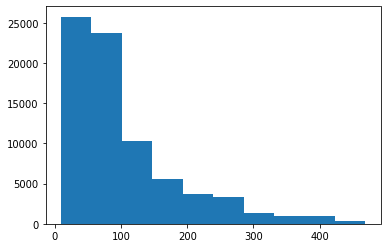

In [7]:
# plot a histogram
plt.hist(lengths)

In [8]:
# describe stats
stats.describe(lengths)

DescribeResult(nobs=76230, minmax=(9, 469), mean=104.01298701298701, variance=7295.900735190769, skewness=1.6223863456381131, kurtosis=2.571300071849702)

From the above diagram and stats, we know that the reviews are short enough to fit into the model

## 2 Establish Naive Baseline

### 2.1 Entity-Aspect Classification Task

In this section, we examine the training data file, `EN_Laptop_Train_Complete_NLI_M.csv` (the complete training set) to determine the baseline to use for our metrics. Ideally, our cross-lingual model should perform better than the baseline to show that training using English data will help the model to perform the same task in Chinese.

In [9]:
data_dir='./data/semeval2016/bert-pair/text-level/'

file_name = 'EN_Laptop_Text_Train_Complete'
task_name = 'NLI_M'

train_df = pd.read_csv(data_dir+file_name+"_"+task_name+".csv", sep = "\t", names = ["sent_id", "polarity", "entity-aspect", "text"])

In [10]:
# get a series with sentence as id and the number of entity-aspects associated with as value and summarize the stats
train_df["quant_pol"] = train_df.polarity.map({'positive':1, 'neutral':1, 'negative':1, 'conflict':1,'none':0})
train_df.groupby(by = ["sent_id"]).quant_pol.sum().describe()

count    385.000000
mean       5.200000
std        2.423625
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       14.000000
Name: quant_pol, dtype: float64

In [11]:
# View the top 5 most common entity-aspect combo
count_df = train_df.loc[train_df["polarity"] != "none", ["sent_id", "entity-aspect"]] \
                   .groupby(by="entity-aspect") \
                   .agg(count = ("sent_id", "count"))
count_df.sort_values(by = "count", ascending=False) \
        .head(5)

,count
entity-aspect,
LAPTOP-GENERAL,385
LAPTOP-OPERATION_PERFORMANCE,190
LAPTOP-DESIGN_FEATURES,150
LAPTOP-QUALITY,148
LAPTOP-PRICE,114


From the above EDA, we see that both the average and median number of aspect categories associated with a review is closest to five. A reasonable baseline could be using the just the most common 5 aspect categories above as the guesses for the entity-aspect classification task.

### 2.2 How we stablish naive baseline for sentiment classification task

The sentiment classification task evaluates the sentiments for different entity-aspect combination separately. Therefore, since we have 198 combinations, we will need 198 different sentiments as baselines for the entity-aspect combos respectively. 

In addition, we will calculate the probability weights of different sentiments for a given aspect category by counting the number of reviews associated with that particular aspect category and sentiment and then normalize. So we can use the resulting weights to calculate 3 class and 2 class accuracies. 

Lastly, we will also use the most common sentiments in the training set as prediction for entity-aspect combination that exists in test set but not in the training set.

Acceptable sentiments are non-none.

### 2.3 Make Baseline Files

In [12]:
test_file = "./data/semeval2016/bert-pair/text-level/EN_Laptop_Text_Test_Gold_NLI_M.csv"
df_test = pd.read_csv(test_file, 
                     delimiter = "\t",
                     names = ["sent_id", "label", "entity-aspect", "text"]
                     )
map_dict = {'positive':0, 'neutral':1, 'negative':2, 'conflict':3, 'none':4}


Calculate the probability weights by counting reviews in the training file

In [13]:
pol_by_aspect = train_df.loc[:,["sent_id", "polarity", "entity-aspect"]] \
                        .groupby(by = ["entity-aspect", "polarity"]) \
                        .agg(count = ("sent_id", "count")) \
                        .unstack(fill_value = 0)
pol_by_aspect.columns = pol_by_aspect.columns.droplevel()
pol_by_aspect = pol_by_aspect[["positive", "neutral", "negative", "conflict", "none"]]

In [14]:
baseline_probs = pol_by_aspect.divide(pol_by_aspect.sum(axis=1), axis=0)

Modify the sentiment prediction and probability weights for the top 5 aspect categories identified in Section 2.1

In [15]:
baseline_probs.insert(loc = 0, column = "pred", value = "none")
baseline_probs.loc["LAPTOP-GENERAL", :] = ["positive", 1.0, 0.0, 0.0, 0.0, 0.0]
baseline_probs.loc["LAPTOP-OPERATION_PERFORMANCE", :] = ["positive", 1.0, 0.0, 0.0, 0.0, 0.0]
baseline_probs.loc["LAPTOP-DESIGN_FEATURES", :] = ["positive", 1.0, 0.0, 0.0, 0.0, 0.0]
baseline_probs.loc["LAPTOP-PRICE", :] = ["positive", 1.0, 0.0, 0.0, 0.0, 0.0]
baseline_probs.loc["LAPTOP-QUALITY", :] = ["negative", 0.0, 0.0, 1.0, 0.0, 0.0]
baseline_probs["pred"] = baseline_probs.pred.map(map_dict)
baseline_probs = baseline_probs.reset_index()

In [17]:
test_baseline_df = df_test.reset_index().merge(baseline_probs)

In [18]:
test_baseline_df = test_baseline_df.sort_values(by="index")

In [19]:
# Uncomment to SAVE THE TEST BASELINE FILES
# for i in range(6):
#     test_baseline_df.iloc[:,-6:].to_csv(f"results/semeval2016/text-level/Test_Baseline/test_ep_{i+1}.txt", sep = " ", index=False, header=False)

## 3 Sampling Strategy Exploration

In this section, we listed the sampling strategies used in the projects and the resulting label proportion in the training set.

In [20]:
data_dir='./data/semeval2016/bert-pair/text-level/'

file_name = 'EN_Laptop_Text_Train'
task_name = 'NLI_M'

df_train = pd.read_csv(data_dir+file_name+"_"+task_name+".csv", sep = "\t", names = ["sent_id", "label", "entity-aspect", "text"])
map_dict = {'positive':0, 'neutral':1, 'negative':2, 'conflict':3, 'none':4}
df_train["label"] = df_train.label.map(map_dict)

In [21]:
#Iteration 2, Model Name: Combo-Samping-1
#Duplicate each non-none example by a factor of 2
#Randomly drop 50 percent of none examples
count_by_2016 = df_train.groupby(by="label").sent_id.count()
count_by_2016.iloc[:4] = count_by_2016.iloc[:4]*2
count_by_2016.iloc[4] = count_by_2016.iloc[4]*0.5
print("Combo-Samping-1")
print(count_by_2016/count_by_2016.sum())
print("="*40)

#Iteration 2, Model Name: Combo-Samping-2
#Duplicate each non-none example by a factor of 3
#Randomly drop 0.55 percent of none examples
count_by_2016 = df_train.groupby(by="label").sent_id.count()
count_by_2016.iloc[:4] = count_by_2016.iloc[:4]*3
count_by_2016.iloc[4] = count_by_2016.iloc[4]*0.45
print("Combo-Samping-2")
print(count_by_2016/count_by_2016.sum())
print("="*40)

#Iteration 2, Model Name: Combo-Samping-3
#Duplicate each non-none example by a factor of 5
#Randomly drop 60 percent of none examples
count_by_2016 = df_train.groupby(by="label").sent_id.count()
count_by_2016.iloc[:4] = count_by_2016.iloc[:4]*5
count_by_2016.iloc[4] = count_by_2016.iloc[4]*0.4
print("Combo-Samping-3")
print(count_by_2016/count_by_2016.sum())
print("="*40)

#Iteration 3, Model Name: Over-Sampling-1
#Duplicate each non-none example by a factor of 2
count_by_2016 = df_train.groupby(by="label").sent_id.count()
count_by_2016.iloc[:4] = count_by_2016.iloc[:4]*2
print("Over-Sampling-1")
print(count_by_2016/count_by_2016.sum())
print("="*40)

#Iteration 3, Model Name: Over-Sampling-2
#Duplicate
#positive example by a factor of 1.5
#neutral example by a factor of 3
#negative example by a factor of 2.2
#conflict example by a factor of 5
count_by_2016 = df_train.groupby(by="label").sent_id.count()
count_by_2016.iloc[0] = count_by_2016.iloc[0]*1.5
count_by_2016.iloc[1] = count_by_2016.iloc[1]*3
count_by_2016.iloc[2] = count_by_2016.iloc[2]*2.2
count_by_2016.iloc[3] = count_by_2016.iloc[3]*5
print("Over-Sampling-2")
print(count_by_2016/count_by_2016.sum())
print("="*40)

Combo-Samping-1
label
0    0.054508
1    0.006207
2    0.033676
3    0.001905
4    0.903704
Name: sent_id, dtype: float64
Combo-Samping-2
label
0    0.085367
1    0.009720
2    0.052741
3    0.002984
4    0.849188
Name: sent_id, dtype: float64
Combo-Samping-3
label
0    0.141403
1    0.016101
2    0.087361
3    0.004942
4    0.750193
Name: sent_id, dtype: float64
Over-Sampling-1
label
0    0.028633
1    0.003260
2    0.017690
3    0.001001
4    0.949417
Name: sent_id, dtype: float64
Over-Sampling-2
label
0    0.021523
1    0.004902
2    0.019503
3    0.002507
4    0.951565
Name: sent_id, dtype: float64
